In [1]:
pip install PyMySQL

     |████████████████████████████████| 43 kB 3.0 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c conda-forge ta-lib

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::nbclient==0.5.2=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - conda-forge/noarch::qdarkstyle==2.8.1=pyhd8ed1ab_2
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/linux-64::widgetsnbextension==3.5.1=py36h5fab9bb_4
  - conda-forge/noarch::flake8==3.8.4=py_0
  - conda-forge/noarch::ipywidgets==7.6.3=pyhd3deb0d_0
  - conda-forge/noarch::typing-extensions==3.7.4.3=0
  - conda-forge/noarch::path.py==12.5.0=0
  - conda-forge/noarch::dask==2021.2.0=pyhd8ed1ab_0
  - conda-forge/noarch::nbformat==5.1.2=pyhd8ed1ab_1
  - conda-forge/linux-64::path==15.1.2=py36h5fab9bb_0
  - conda-forge/linux-64::nbconvert==6.0.7=py36h5fab9bb_3
  - conda-forge/linux-64::distributed==2021.2.0=py36h5fab9bb_0
  - conda-f

In [1]:
import pymysql
import boto3
import sagemaker
import pandas as pd
import talib
import numpy as np
import json

In [66]:
# get the role of this notebook
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# the s3 path
bucket = 'capstone-sagemaker-bucket'
prefix = 'xgb-data'

indicator_ndays = 100

# sagemaker session download csv to current path
sm_session = sagemaker.Session()
print(sm_session.default_bucket())
#sm_session.download_data("./", bucket, prefix + "/aapl.csv")

# load data from s3
#X_full = pd.read_csv("./aapl.csv")
#X_full.head(3)

sagemaker-us-east-1-499362316899


# Load Data

In [3]:
def mysql_query(sql):
    endpoint = 'capstonedb.c2exfkakcxag.us-east-1.rds.amazonaws.com'
    username = 'admin'
    password = 'abcd1234'
    database_name = 'stock'

    # connection
    connection = pymysql.connect(host=endpoint, user=username,
                                password=password, database=database_name)

    cursor = connection.cursor()
    cursor.execute(sql)

    rows = cursor.fetchall()

    #for row in rows:
        #print("{0} {1} {2}".format(row[0], row[1], row[2]))
    #    print(row)
    #    break
    
    cursor.close()
    connection.close()
    
    return rows

In [4]:
sql = 'select * from stock.t_stock_daily where ticket = "AMD" order by trade_date asc'
rows = mysql_query(sql)
stock_df = pd.DataFrame(rows, columns=['trade_date', 'open', 'high', 'low', 'close', 'volume', 
                            'dividends', 'stock_splits', 'ticket', 'sector'])
stock_df.head(3)

,trade_date,open,high,low,close,volume,dividends,stock_splits,ticket,sector
0,2019-04-05,29.639999,29.690001,28.799999,28.980000,65662700.0,0.0,0.0,AMD,Technology
1,2019-04-08,28.690001,28.950001,28.180000,28.530001,58002500.0,0.0,0.0,AMD,Technology
2,2019-04-09,28.240000,28.379999,27.190001,27.240000,75539800.0,0.0,0.0,AMD,Technology


# Selected Technical Indicators 

- n: For example n = 10

- 1. Simple n-day moving average = (𝐶t + ... 𝐶t-n+1) / n
- 2. Weighted n-day moving average = (𝑛∗𝐶𝑡+(𝑛−1)∗𝐶𝑡−1+⋯+𝐶𝑡−𝑛+1) / (𝑛+(𝑛−1)+⋯+1)
- 3. Relative strength index (RSI) = https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
- 4. Price rate = ( open(t) - open(t-1) ) / ( max(high in n) - min(low in n) )
- 5. Volume rate = ( v(t) - v(t-1) ) / ( max(v in n) - min(v in n) )
- 6. Commodity Channel Index = https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci
- 7. Force Index = https://school.stockcharts.com/doku.php?id=technical_indicators:force_index
- 8. Rate of Change (ROC) = https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
- 9. Bollinger Bands = https://school.stockcharts.com/doku.php?id=technical_indicators:bollinger_bands
- 10. Momentum = 𝐶𝑡 − 𝐶𝑡−𝑛+1

𝐶𝑡 is the closing price at time t

open(t) is the opening price at time t

v(t) is the volume at time t

In [5]:
# Simple Moving Average
# https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages
def SMA(data, ndays):
    SMA = pd.Series(data['close'].rolling(ndays, min_periods = 1).mean(), name = 'sma_' + str(ndays))
    data = data.join(SMA)
    return data

# Weighted n-day moving average
def WMA(data, ndays):
    name = 'wma_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data

# Relative strength index (RSI)
def RSI(data, ndays):
    name = 'rsi_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data

# ( open(t) - open(t-1) ) / ( max(high in ndays) - min(low in ndays) )
def p_rate_period_n(data, ndays):
    ot = data['open'].diff(1)
    max_high = data['high'].rolling(ndays, min_periods = 1).max()
    min_low = data['low'].rolling(ndays, min_periods = 1).min()
    
    p_open_ = pd.Series(ot / (max_high - min_low), name='p_rate_period_' + str(ndays))
    data = data.join(p_open_)
    return data


# ( v(t) - v(t-1) ) / ( max(v in ndays) - min(v in ndays) )
def v_rate_period_n(data, ndays):
    ot = data['volume'].diff(1)
    max_high = data['volume'].rolling(ndays, min_periods = 1).max()
    min_low = data['volume'].rolling(ndays, min_periods = 1).min()
    
    p_open_ = pd.Series(ot / (max_high - min_low), name='v_rate_period_' + str(ndays))
    data = data.join(p_open_)
    return data

# Commodity Channel Index
def CCI(data, ndays):
    name = 'cci_' + str(ndays)
    data[name] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=ndays)
    return data

# Force Index 
def ForceIndex(data, ndays):
    FI = pd.Series(data['close'].diff(ndays) * data['volume'], name = 'force_index_' + str(ndays))
    data = data.join(FI)
    return data

# Rate of Change (ROC)
def ROC(data, ndays):
    name = 'roc_' + str(ndays)
    data[name] = talib.ROC(data['close'], timeperiod=ndays)
    return data

# Bollinger Bands
def BollingerBands(data, ndays, col_name='close'):
    MA = data[col_name].rolling(ndays, min_periods = 1).mean()
    SD = data[col_name].rolling(ndays, min_periods = 1).std()
    
    b1 = MA + (2 * SD)
    B1 = pd.Series(b1, name = 'bband_upper_' + str(ndays))
    data = data.join(B1)
    
    b2 = MA - (2 * SD)
    B2 = pd.Series(b2, name = 'bband_lower_' + str(ndays))
    data = data.join(B2) 
    return data

def Momentum(data, ndays):
    name = 'mom_' + str(ndays)
    data[name] = talib.MOM(data['close'], timeperiod=ndays)
    return data


def add_indicators(data, ndays = 10):
    data = SMA(data, ndays)
    data = WMA(data, ndays)
    data = RSI(data, ndays)
    data = p_rate_period_n(data, ndays)
    data = v_rate_period_n(data, ndays)
    data = CCI(data, ndays)
    data = ForceIndex(data, ndays)
    data = ROC(data, ndays)
    data = BollingerBands(data, ndays)
    data = Momentum(data, ndays)
    
    return data

In [6]:
# use it to create different period for indicators

def indicator_names(ndays):
    arr = ['trade_date', 'close', 'open', 'high', 'low', 'volume',
           'sma_' + str(ndays), 'wma_' + str(ndays), 'rsi_' + str(ndays), 'p_rate_period_' + str(ndays), 
           'v_rate_period_' + str(ndays), 'cci_' + str(ndays), 'force_index_' + str(ndays), 'roc_' + str(ndays), 
           'bband_upper_' + str(ndays), 'bband_lower_' + str(ndays), 'mom_' + str(ndays)]

    return arr
    
def get_model_df(data, ndays):
    df_ = add_indicators(data, ndays)
    df_ = df_.iloc[ndays:, :]
    print(df_.shape)
    return df_[indicator_names(ndays)]


def df_cols_to_obj(data_df, target_col_name, dynamic_feat_cols):
    d_feats = []
    for f in dynamic_feat_cols:
        d_feats.append(list(data_df[f]))
        
    obj = {"start": str(data_df.index[0]), 
           "target": list(data_df[target_col_name]),
           "dynamic_feat":d_feats}
    
    return json.dumps(obj)

def save_json_to_s3(indicator_ndays, X_deepAR_train, X_deepAR_test):
    encoding = "utf-8"
    FILE_TRAIN = "train.json"
    FILE_TEST = "test.json"
    target_col_name = "close"

    with open(FILE_TRAIN, "wb") as f:
        obj_ = df_cols_to_obj(X_deepAR_train, target_col_name, dynamic_feat_cols)
        f.write(obj_.encode(encoding))
        f.write("\n".encode(encoding))

    with open(FILE_TEST, "wb") as f:
        obj_ = df_cols_to_obj(X_deepAR_test, target_col_name, dynamic_feat_cols)
        f.write(obj_.encode(encoding))
        f.write("\n".encode(encoding))

    s3 = boto3.client("s3")
    s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/{}/".format(str(indicator_ndays)) + FILE_TRAIN)
    s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/{}/".format(str(indicator_ndays)) + FILE_TRAIN)

def save_json_for_deepAR(data_df, ndays):
        
    # add indicators
    amd_df = get_model_df(data_df, ndays)

    # get train set rows
    training_data_len = int(np.ceil( len(amd_df) * .8 ))
    print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))

    X_deepAR_close = amd_df.copy()

    X_deepAR_close.set_index('trade_date', inplace=True)

    # train set
    X_deepAR_train = X_deepAR_close[:training_data_len]

    # test set contains the full range of each time series.
    X_deepAR_test = X_deepAR_close[:]

    # save json of train and test into s3. s3://capstone-sagemaker-bucket/xgb-data/data/train/10/train.json
    save_json_to_s3(ndays, X_deepAR_train, X_deepAR_test)
    
    return X_deepAR_train, X_deepAR_test, training_data_len

In [67]:
# get all indicators
all_indicator_names = indicator_names(indicator_ndays)
dynamic_feat_cols = all_indicator_names[2:]
print(dynamic_feat_cols)

['open', 'high', 'low', 'volume', 'sma_100', 'wma_100', 'rsi_100', 'p_rate_period_100', 'v_rate_period_100', 'cci_100', 'force_index_100', 'roc_100', 'bband_upper_100', 'bband_lower_100', 'mom_100']


# Save json files into s3

In [68]:
X_deepAR_train, X_deepAR_test, training_data_len = save_json_for_deepAR(stock_df.copy(), indicator_ndays)

(665, 21)
train_length:532, test_length:133


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# Train a model

In [11]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
sagemaker_session = sm_session

In [12]:
def fit_model(indicator_ndays, X_deepAR_close, training_data_len):
    
    s3_data_path = f"{bucket}/{prefix}/data"
    s3_output_path = f"{bucket}/{prefix}/output/{str(indicator_ndays)}/"

    deepar_estimator = sagemaker.estimator.Estimator(
        sagemaker_session=sagemaker_session,
        image_uri=image_uri,
        role=role,
        instance_count=1,
        instance_type="ml.c4.xlarge",
        base_job_name="aapl-deepar",
        output_path=f"s3://{s3_output_path}",
    )
    
    freq = "D"
    context_length = X_deepAR_close.shape[0]
    print(context_length)

    prediction_length = X_deepAR_close.shape[0] - training_data_len
    print(prediction_length)

    hyperparameters = {
        "time_freq": freq,
        "context_length": str(prediction_length),
        "prediction_length": str(prediction_length),
        "num_cells": "40",
        "num_layers": "3",
        "likelihood": "gaussian",
        "epochs": "20",
        "mini_batch_size": "32",
        "learning_rate": "0.001",
        "dropout_rate": "0.05",
        "early_stopping_patience": "10",
        "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
    }
    
    deepar_estimator.set_hyperparameters(**hyperparameters)
    
    
    data_channels = {"train": f"s3://{s3_data_path}/train/{str(indicator_ndays)}/", 
                     "test": f"s3://{s3_data_path}/test/{str(indicator_ndays)}/"}

    deepar_estimator.fit(inputs=data_channels)
    
    return deepar_estimator

In [13]:
def train_model(data_df, indicator_ndays):
    
    # add indicators
    amd_df = get_model_df(data_df, indicator_ndays)

    # get train set rows
    training_data_len = int(np.ceil( len(amd_df) * .8 ))
    print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))

    X_deepAR_close = amd_df.copy()

    deepar_estimator = fit_model(indicator_ndays, X_deepAR_close, training_data_len)
    
    return deepar_estimator

# Train models with different ndays (10, 20, 50, 100)

In [14]:
# 10
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 10 days for indicators
(755, 21)
train_length:604, test_length:151
755
151
2022-04-29 04:36:43 Starting - Starting the training job...
2022-04-29 04:36:58 Starting - Preparing the instances for trainingProfilerReport-1651207002: InProgress
.........
2022-04-29 04:38:43 Downloading - Downloading input data...
2022-04-29 04:39:03 Training - Downloading the training image......
2022-04-29 04:40:04 Training - Training image download completed. Training in progress.Arguments: train
[04/29/2022 04:40:05 INFO 139945760736640 integration.py:592] worker started
[04/29/2022 04:40:05 INFO 139945760736640] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mi

In [36]:
# 20
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 20 days for indicators
(745, 21)
train_length:596, test_length:149
745
149
2022-04-29 04:55:22 Starting - Starting the training job...ProfilerReport-1651208122: InProgress
...
2022-04-29 04:56:13 Starting - Preparing the instances for training......
2022-04-29 04:57:19 Downloading - Downloading input data
2022-04-29 04:57:19 Training - Downloading the training image......
2022-04-29 04:58:20 Training - Training image download completed. Training in progress..Arguments: train
[04/29/2022 04:58:27 INFO 139955626059136 integration.py:592] worker started
[04/29/2022 04:58:27 INFO 139955626059136] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini

In [53]:
# 50
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 50 days for indicators
(715, 21)
train_length:572, test_length:143
715
143
2022-04-29 05:11:19 Starting - Starting the training job...
2022-04-29 05:11:42 Starting - Preparing the instances for trainingProfilerReport-1651209079: InProgress
.........
2022-04-29 05:13:02 Downloading - Downloading input data...
2022-04-29 05:13:42 Training - Downloading the training image.....Arguments: train
[04/29/2022 05:14:30 INFO 140368729425280 integration.py:592] worker started
[04/29/2022 05:14:30 INFO 140368729425280] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples':

In [69]:
# 100
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 100 days for indicators
(665, 21)
train_length:532, test_length:133
665
133
2022-04-29 05:27:03 Starting - Starting the training job...
2022-04-29 05:27:20 Starting - Preparing the instances for trainingProfilerReport-1651210022: InProgress
.........
2022-04-29 05:28:45 Downloading - Downloading input data......
2022-04-29 05:29:45 Training - Downloading the training image..Arguments: train

2022-04-29 05:30:26 Training - Training image download completed. Training in progress.[04/29/2022 05:30:18 INFO 140590252332416 integration.py:592] worker started
[04/29/2022 05:30:18 INFO 140590252332416] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mi

# Deploy an endpoint

In [70]:
# Create endpoint and predictor
# Note: remember to delete the endpoint after running this experiment. 
# A cell at the very bottom of this notebook will do that: make sure you run it at the end.

job_name = deepar_estimator_model.latest_training_job.name
print("job_name = {}".format(job_name))

#image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)

endpoint_name = sm_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

job_name = aapl-deepar-2022-04-29-05-27-02-857
------------!

# Make predictions and plot results

In [16]:
freq = "D"
target_col_name = "close"

In [17]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None, dynamic_feat[k] if dynamic_feat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [71]:
prediction_length = X_deepAR_test.shape[0] - X_deepAR_train.shape[0]
prediction_length

133

In [72]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sm_session)
predictor.set_prediction_parameters(freq, prediction_length)

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Use train set to predict

In [73]:
time_series = []
index = pd.date_range(start=X_deepAR_train.index[0], freq=freq, periods=X_deepAR_train.shape[0])
time_series.append(pd.Series(data=X_deepAR_train['close'].to_numpy(), index=index))

In [74]:
# Create dynamic feat. The length of dynamic feat = ( lenghth of train + length of predition)
# e.g. If we want to predict 150 points. 
# The length of dynamic feat = length of train + 150 of points
d_feats = []
for f in dynamic_feat_cols:
    d_feats.append(list(X_deepAR_test[f]))

In [75]:
len(d_feats[0])

665

In [76]:
d_feats_arr = [d_feats]

# Predict [10, 20, 50, 100] different number of samples to compute at prediction time

In [78]:
back_samples = [10, 20, 50, 100]
def predict_diff_back_view_samples():
    
    
    results = []
    results_list_of_df = []
    for num_samples in back_samples:
        list_of_df_ = predictor.predict(ts=time_series[:1], cat=None, dynamic_feat=d_feats_arr, 
                               num_samples = num_samples, content_type="application/json")
        
        # get RMSE
        rmse_= np.sqrt(np.mean(np.power((X_deepAR_test['close'][-prediction_length:].values - list_of_df_[0]["0.5"].values), 2)))
        
        # get earn pct
        earn_pct_ = cal_earn_pct(X_deepAR_test['close'][-prediction_length:].values, list_of_df_[0]["0.5"].values)
        
        re_dict = {"indicator_days":indicator_ndays, "back_view_samples":num_samples, "rmse":rmse_, "earn_pct":earn_pct_}

        results.append(re_dict)
        
        results_list_of_df.append(list_of_df_)
        
    return results, results_list_of_df

# real_closes is np.array, predicted_closes is np.array
def cal_earn_pct(real_closes, predicted_closes):
    real_closes_df = pd.DataFrame(real_closes, columns=['real_close'])
    p_closes_df = pd.DataFrame(predicted_closes, columns=['close'])
    
    predicted_closes_df = pd.concat([real_closes_df,p_closes_df], axis=1)
    
    start_cash = 1000000
    
    init_cash = 1000000
    hold_number_stocks = 0
    
    symbol = 'income'
    bought = {symbol:'OUT'}
    trade_lst = []
    sold_lst = []
    # amd_df['direction'] = np.sign(amd_df["close"].pct_change()*100.0)
    # predicted_closes_df = pd.DataFrame([predicted_closes], columns=['close'])
    
    
    predicted_closes_df['predict_direction'] = np.sign(predicted_closes_df["close"].pct_change()*100.0)
    
    for index, row in predicted_closes_df.iterrows():
        
        change_pct = 0.0
        if trade_lst:
            last_one = trade_lst[-1]
            
            change_pct = (row['real_close'] / last_one[0] - 1) * 100
                
        if row['predict_direction'] > 0.0 and bought[symbol] == 'OUT':
            
            trade_lst.append(row)
            
            number_stocks = init_cash // row['real_close']
            hold_number_stocks = number_stocks

            spend = number_stocks * row['real_close']
            #print(init_cash)
            init_cash -= spend


            bought[symbol] = 'LONG'
            continue
            
        elif bought[symbol] == 'LONG' and ( (row['predict_direction'] < 0.0) or change_pct > 1.0 or change_pct < -1.0 ):
            sold_lst.append(row)

            sold = hold_number_stocks * row['real_close']
            #print('sold:' + str(sold))
            #print('init_cash:' + str(init_cash))
            init_cash += sold
            #print('---' + str(init_cash))

            hold_number_stocks = 0
            bought[symbol] = 'OUT'
            continue

    
    cash = init_cash + hold_number_stocks * trade_lst[-1][0]
    #print(cash)
    earn_pct = (cash / start_cash - 1) * 100
    #print(earn_pct)
    return round(earn_pct, 2)

predict_results, results_list_of_df = predict_diff_back_view_samples()

In [26]:
indicator_10_result = pd.DataFrame(predict_results)
indicator_10_result

,indicator_days,back_view_samples,rmse,earn_pct
0,10,10,9.584918,-41.82
1,10,20,9.056423,-14.21
2,10,50,8.472811,-14.83
3,10,100,8.090721,-29.77


In [45]:
indicator_20_result = pd.DataFrame(predict_results)
indicator_20_result

,indicator_days,back_view_samples,rmse,earn_pct
0,20,10,22.384015,38.88
1,20,20,23.120596,27.81
2,20,50,23.717314,6.77
3,20,100,23.501075,24.70


In [62]:
indicator_50_result = pd.DataFrame(predict_results)
indicator_50_result

,indicator_days,back_view_samples,rmse,earn_pct
0,50,10,25.538177,5.52
1,50,20,26.295990,-23.02
2,50,50,25.633668,-33.72
3,50,100,26.143189,14.22


In [79]:
indicator_100_result = pd.DataFrame(predict_results)
indicator_100_result

,indicator_days,back_view_samples,rmse,earn_pct
0,100,10,21.059287,-31.49
1,100,20,20.848629,8.95
2,100,50,20.223853,-29.74
3,100,100,20.278307,-31.16


In [80]:
all_ind_results = pd.concat([indicator_10_result, indicator_20_result, indicator_50_result, indicator_100_result])

In [81]:
all_ind_results.sort_values(by=['rmse'])

,indicator_days,back_view_samples,rmse,earn_pct
3,10,100,8.090721,-29.77
2,10,50,8.472811,-14.83
1,10,20,9.056423,-14.21
0,10,10,9.584918,-41.82
2,100,50,20.223853,-29.74
3,100,100,20.278307,-31.16
1,100,20,20.848629,8.95
0,100,10,21.059287,-31.49
0,20,10,22.384015,38.88
1,20,20,23.120596,27.81


In [83]:
all_ind_results.sort_values(by=['earn_pct'], ascending=False)

,indicator_days,back_view_samples,rmse,earn_pct
0,20,10,22.384015,38.88
1,20,20,23.120596,27.81
3,20,100,23.501075,24.70
3,50,100,26.143189,14.22
1,100,20,20.848629,8.95
2,20,50,23.717314,6.77
0,50,10,25.538177,5.52
1,10,20,9.056423,-14.21
2,10,50,8.472811,-14.83
1,50,20,26.295990,-23.02


# View the predictions

In [46]:
# Prepar data set for plots
actual_data_time_series = []
index = X_deepAR_test.index
actual_data_time_series.append(pd.Series(data=X_deepAR_test['close'].to_numpy(), index=index))

In [28]:
import matplotlib.pyplot as plt

In [29]:
def draw_line():
    for k in range(len(results_list_of_df)):
        plt.figure(figsize=(12, 6))
        #actual_data_time_series[k][- context_length :].plot(label="target")
        actual_data_time_series[0][- prediction_length :].plot(label="target")
        p10 = results_list_of_df[k][0]["0.1"]
        p90 = results_list_of_df[k][0]["0.9"]
        plt.fill_between(actual_data_time_series[0][- prediction_length :].index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
        p50 = pd.Series(data=results_list_of_df[k][0]["0.5"].to_numpy(), index=actual_data_time_series[0][- prediction_length :].index)
        p50.plot(label="prediction median")
        plt.legend()
        plt.title("Indicators = {}, Back view samples = {}".format(str(indicator_ndays), str(back_samples[k])))
        plt.show()

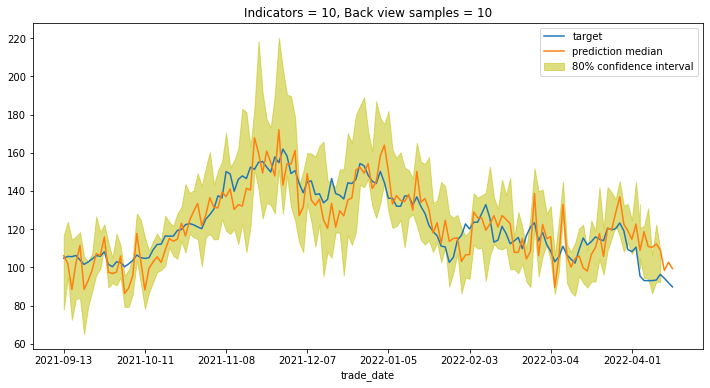

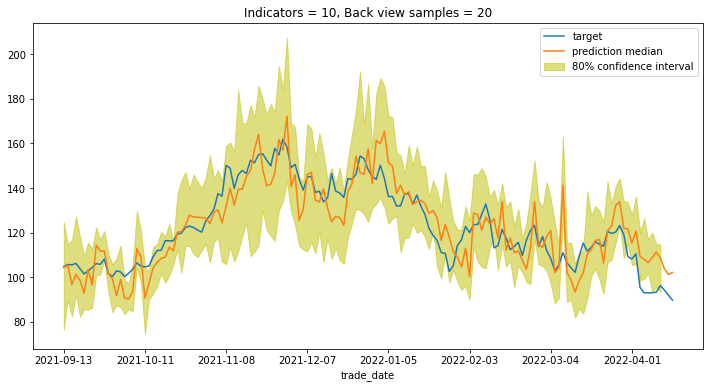

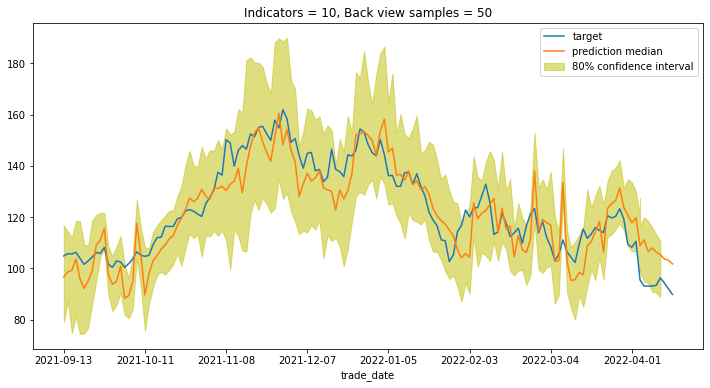

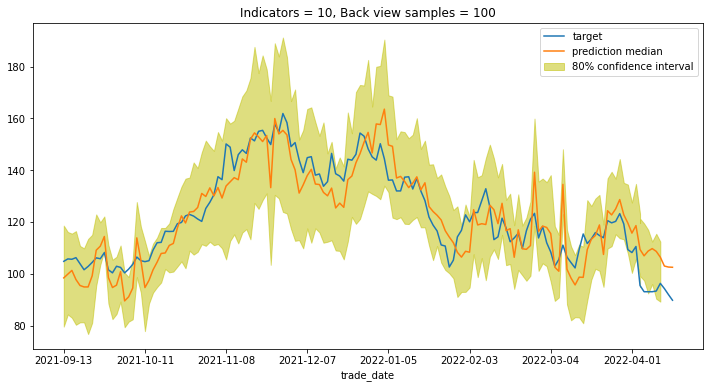

In [30]:
# 10
draw_line()

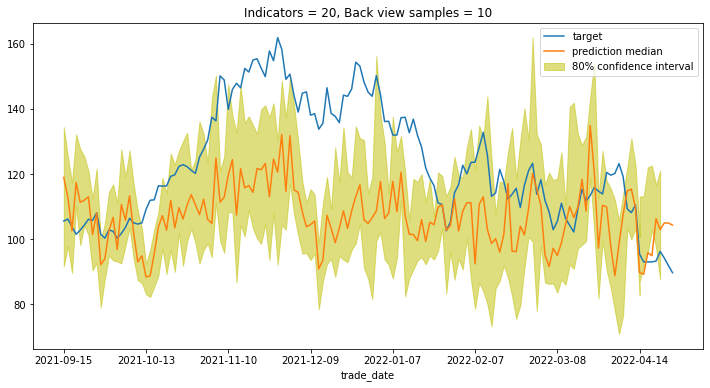

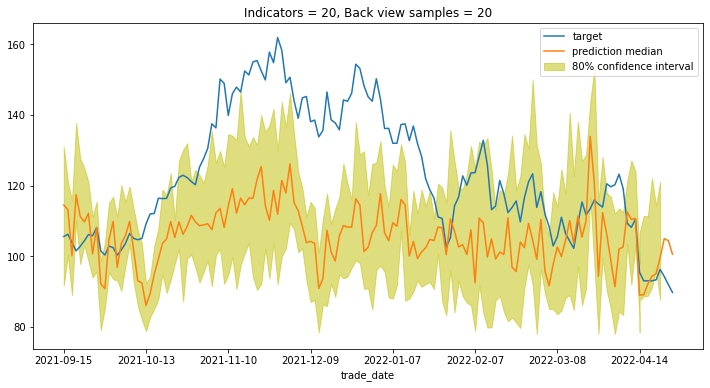

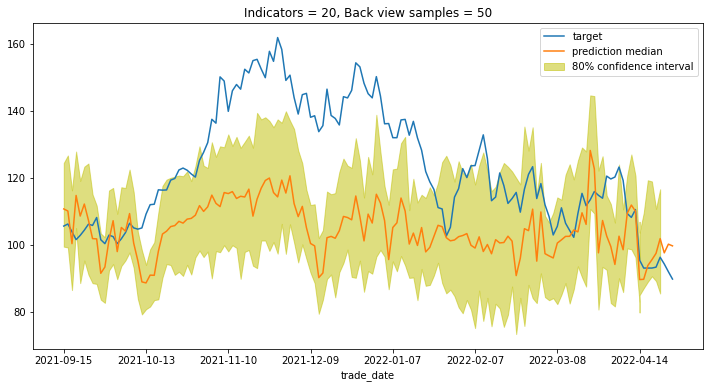

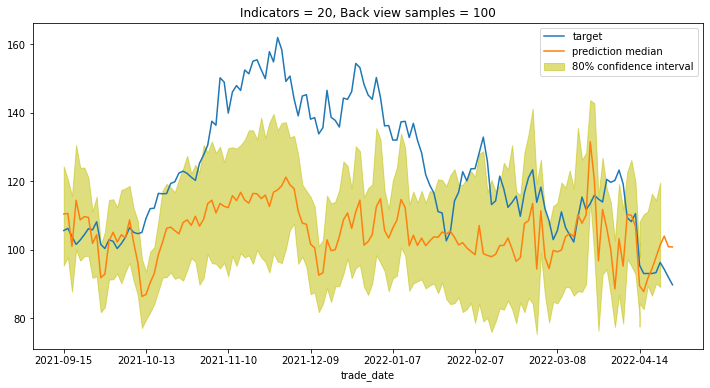

In [47]:
# 20
draw_line()

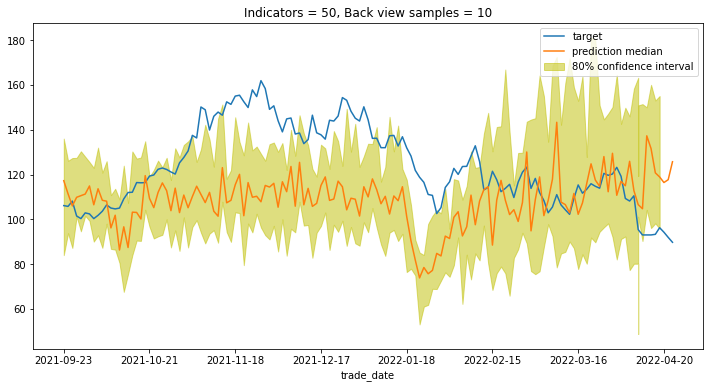

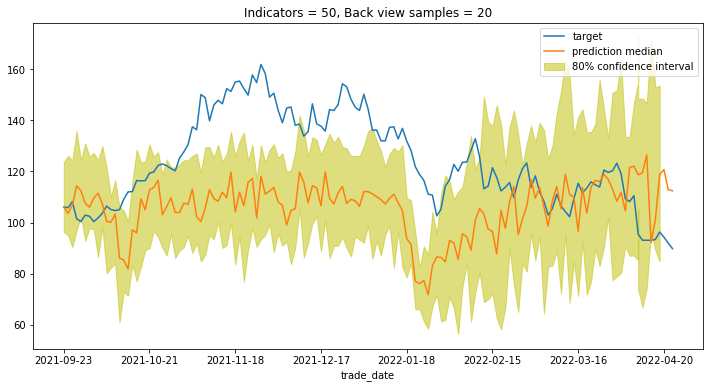

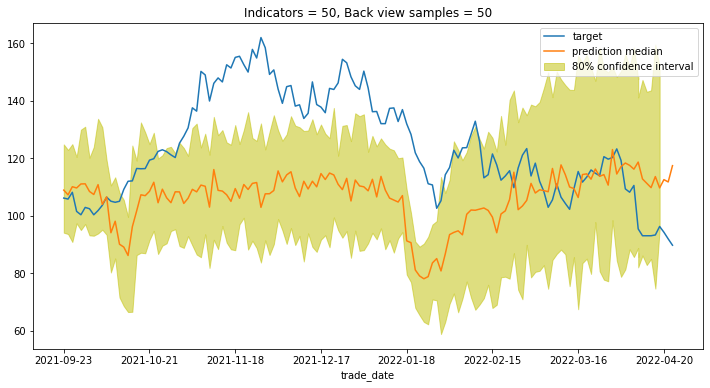

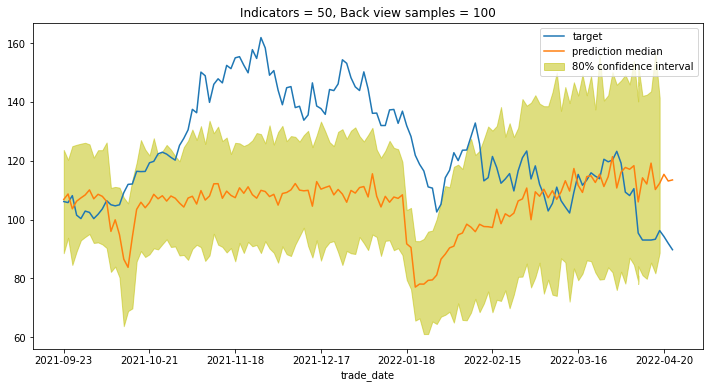

In [63]:
# 50
draw_line()

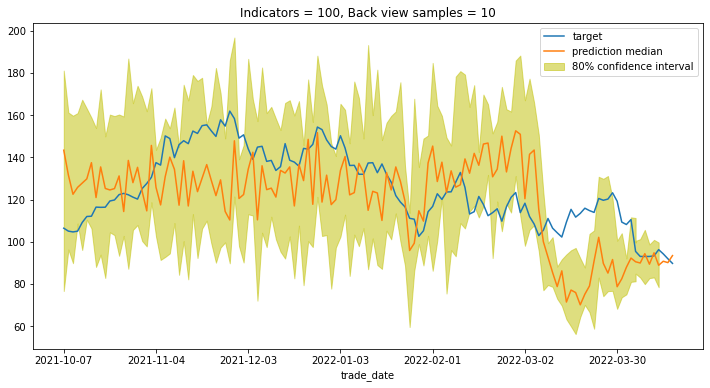

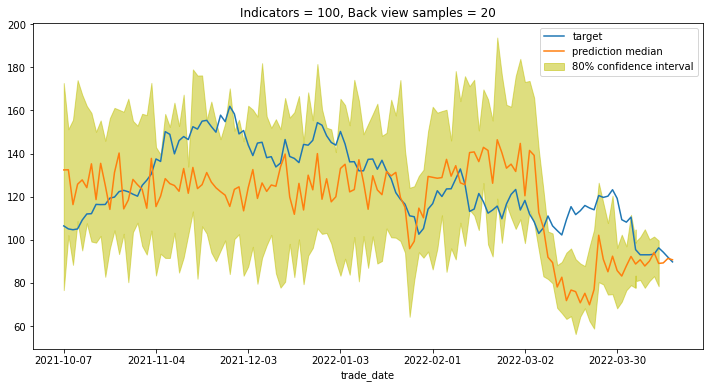

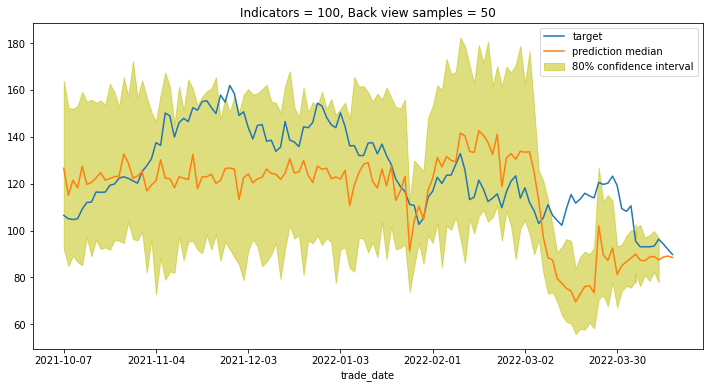

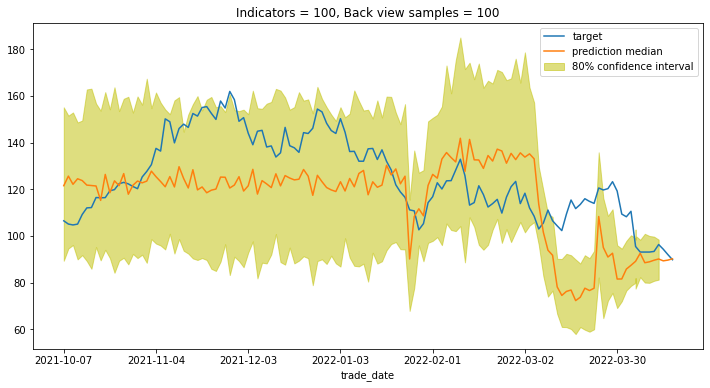

In [84]:
# 100
draw_line()

# Delete EndPoint

In [85]:
sm_session.delete_endpoint(endpoint_name)

In [86]:
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:499362316899:endpoint/aapl-deepar-2022-04-29-05-27-02-857".